### This is a new version of MLEAP scripts, started in late Aug 2022.
It will combine IProject_MLEAP_ANN and IP_MLEAP script, while improving them.

#### Outline

1. Load libraries and data.
2. pEDA. Look at feature distribution, fix them if they do not look right.
3. Train-test split. Most likely couple years into test set. 2015-2018?. Impute missing values.
4. Transform numerical features, add ohe for inds.
5. Fit classic models: ols as a baseline, then xgb.
6. Fir DL.


Notes:
ideally, I want to use time-based cross-validation.
since I have panel data, it is not a trivial task.
need to find some solution online.
e.g., https://towardsdatascience.com/time-based-cross-validation-d259b13d42b8.


In [82]:
# 0. Import libraries #

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, time, math, re, warnings, random, gc, dill, optuna
import statsmodels.api as sm
from random import sample

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNetCV
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance
from category_encoders import MEstimateEncoder
from xgboost import XGBRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

plt.style.use('seaborn-white')
warnings.simplefilter(action='ignore')
pd.set_option('display.max_columns', 110)
gc.enable()

In [83]:
### target encoding ###
# source: https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices/notebook

class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=4)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

In [84]:
# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [85]:
# 1. Import data #

time0 = time.time()
df = pd.read_csv('../input/cpcrsp-46/IMLEAP_v4.csv')
df.dropna(axis=0, subset=['bm', 'lbm', 'llme', 'lop', 'op', 'linv', 'mom122', 'beta_bw', 'ind'], inplace=True)
df.reset_index(inplace=True, drop=True)
df = df.sample(500000)
display(df.shape, df.head(), df.count())

(500000, 46)

,PERMNO,prd,mom482,mom242,year,RET,ind,bm,op,gp,inv,mom11,mom122,amhd,ivol_capm,ivol_ff5,beta_bw,MAX,vol1m,vol6m,vol12m,BAspr,size,lbm,lop,lgp,linv,llme,l1amhd,l1MAX,l1BAspr,l3amhd,l3MAX,l3BAspr,l6amhd,l6MAX,l6BAspr,l12amhd,l12MAX,l12BAspr,l12mom122,l12ivol_capm,l12ivol_ff5,l12beta_bw,l12vol6m,l12vol12m
975260,77550,448,NaN,-25.172631,1995,20.3633,37.0,-0.921099,0.051304,0.238825,-0.058591,-5.211900,0.229153,1.447775,1.068911,0.968758,0.579414,1.6864,1.195066,1.661067,1.879295,2.400000,6.051830,-1.382857,0.048376,0.204294,0.800300,5.926726,1.494200,2.4180,3.174603,1.559902,2.498000,2.500000,1.542140,4.9305,1.818182,1.400283,2.4180,1.666667,-7.775972,1.560456,1.506983,0.982477,2.175515,2.480386
558659,45495,358,-61.508327,0.853492,1988,19.5400,30.0,0.988902,-0.035440,0.000000,-0.031670,18.757600,-4.975264,0.793624,4.504974,3.831267,1.279885,11.3486,5.195766,5.413255,4.641449,NaN,6.108052,0.465380,0.054390,0.083257,0.001939,5.652421,0.835524,13.4955,NaN,1.059063,13.306300,NaN,1.445068,10.3686,NaN,1.805513,13.4955,NaN,-44.494912,4.727320,3.287101,1.102594,3.600322,3.525096
56548,11357,477,-80.628208,-71.003968,1998,-3.8783,35.0,-1.121656,-0.214332,0.266466,-0.230583,-11.704500,45.957415,6.206419,5.063521,3.754773,1.235358,20.3862,3.044110,7.983689,7.756113,2.272727,2.511560,-1.966005,-0.110497,0.121356,0.528983,2.058122,6.209650,7.9790,5.084746,6.233199,21.135115,4.411765,5.162468,13.1349,11.764706,4.285314,7.9790,8.333333,-61.937195,7.874195,6.946893,1.788206,7.484225,7.154533
816941,65365,489,83.282637,71.404567,1999,-12.3326,15.0,-0.548171,0.227291,0.537594,0.081865,26.592465,27.236824,1.767805,2.334386,2.080898,0.703605,7.7608,2.696661,2.930362,2.614708,1.875000,6.264728,-0.544275,0.222820,0.543868,0.069823,5.742089,1.762728,2.5491,2.732240,1.782924,9.781900,2.185792,1.926236,3.1725,1.578947,1.972619,2.5491,2.909091,8.350156,1.571150,1.233580,0.583033,1.862874,1.595597
1207188,88664,384,NaN,-55.289083,1990,11.8100,36.0,-0.040085,0.099706,0.470150,0.107593,-11.751100,-38.371240,7.026280,2.375807,2.075048,-0.123267,3.0960,2.146361,5.348871,4.975181,6.060606,1.949618,-0.141066,0.042753,0.379966,0.800300,2.506179,6.987584,12.4700,5.882353,6.911758,11.081100,6.666667,6.903764,3.8132,7.692308,6.533060,12.4700,6.896552,-12.350618,4.120387,3.502844,0.335250,4.462936,5.153330


PERMNO          500000
prd             500000
mom482          425640
mom242          490560
year            500000
RET             500000
ind             500000
bm              500000
op              500000
gp              500000
inv             499583
mom11           500000
mom122          500000
amhd            411621
ivol_capm       499984
ivol_ff5        499984
beta_bw         500000
MAX             500000
vol1m           499927
vol6m           499516
vol12m          498831
BAspr           290939
size            500000
lbm             500000
lop             500000
lgp             500000
linv            500000
llme            500000
l1amhd          411360
l1MAX           499982
l1BAspr         290183
l3amhd          410762
l3MAX           499891
l3BAspr         288561
l6amhd          409900
l6MAX           499769
l6BAspr         285987
l12amhd         407598
l12MAX          499982
l12BAspr        281245
l12mom122       496568
l12ivol_capm    499529
l12ivol_ff5     499529
l12beta_bw 

<AxesSubplot:>

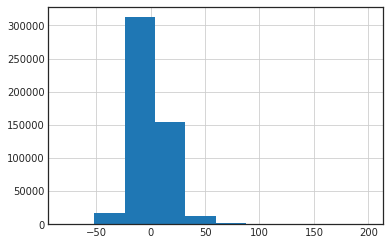

In [86]:
# 2. pEDA #

df.RET.hist()

In [87]:
# explore feature distibution, adjust if seems unreasonable

In [88]:
# add dummies for some missing features

features_miss_dummies = ['amhd', 'BAspr']

for col in features_miss_dummies:
    df[col+'_miss'] = df[col].isnull().astype(int)

df.head()

,PERMNO,prd,mom482,mom242,year,RET,ind,bm,op,gp,inv,mom11,mom122,amhd,ivol_capm,ivol_ff5,beta_bw,MAX,vol1m,vol6m,vol12m,BAspr,size,lbm,lop,lgp,linv,llme,l1amhd,l1MAX,l1BAspr,l3amhd,l3MAX,l3BAspr,l6amhd,l6MAX,l6BAspr,l12amhd,l12MAX,l12BAspr,l12mom122,l12ivol_capm,l12ivol_ff5,l12beta_bw,l12vol6m,l12vol12m,amhd_miss,BAspr_miss
975260,77550,448,NaN,-25.172631,1995,20.3633,37.0,-0.921099,0.051304,0.238825,-0.058591,-5.211900,0.229153,1.447775,1.068911,0.968758,0.579414,1.6864,1.195066,1.661067,1.879295,2.400000,6.051830,-1.382857,0.048376,0.204294,0.800300,5.926726,1.494200,2.4180,3.174603,1.559902,2.498000,2.500000,1.542140,4.9305,1.818182,1.400283,2.4180,1.666667,-7.775972,1.560456,1.506983,0.982477,2.175515,2.480386,0,0
558659,45495,358,-61.508327,0.853492,1988,19.5400,30.0,0.988902,-0.035440,0.000000,-0.031670,18.757600,-4.975264,0.793624,4.504974,3.831267,1.279885,11.3486,5.195766,5.413255,4.641449,NaN,6.108052,0.465380,0.054390,0.083257,0.001939,5.652421,0.835524,13.4955,NaN,1.059063,13.306300,NaN,1.445068,10.3686,NaN,1.805513,13.4955,NaN,-44.494912,4.727320,3.287101,1.102594,3.600322,3.525096,0,1
56548,11357,477,-80.628208,-71.003968,1998,-3.8783,35.0,-1.121656,-0.214332,0.266466,-0.230583,-11.704500,45.957415,6.206419,5.063521,3.754773,1.235358,20.3862,3.044110,7.983689,7.756113,2.272727,2.511560,-1.966005,-0.110497,0.121356,0.528983,2.058122,6.209650,7.9790,5.084746,6.233199,21.135115,4.411765,5.162468,13.1349,11.764706,4.285314,7.9790,8.333333,-61.937195,7.874195,6.946893,1.788206,7.484225,7.154533,0,0
816941,65365,489,83.282637,71.404567,1999,-12.3326,15.0,-0.548171,0.227291,0.537594,0.081865,26.592465,27.236824,1.767805,2.334386,2.080898,0.703605,7.7608,2.696661,2.930362,2.614708,1.875000,6.264728,-0.544275,0.222820,0.543868,0.069823,5.742089,1.762728,2.5491,2.732240,1.782924,9.781900,2.185792,1.926236,3.1725,1.578947,1.972619,2.5491,2.909091,8.350156,1.571150,1.233580,0.583033,1.862874,1.595597,0,0
1207188,88664,384,NaN,-55.289083,1990,11.8100,36.0,-0.040085,0.099706,0.470150,0.107593,-11.751100,-38.371240,7.026280,2.375807,2.075048,-0.123267,3.0960,2.146361,5.348871,4.975181,6.060606,1.949618,-0.141066,0.042753,0.379966,0.800300,2.506179,6.987584,12.4700,5.882353,6.911758,11.081100,6.666667,6.903764,3.8132,7.692308,6.533060,12.4700,6.896552,-12.350618,4.120387,3.502844,0.335250,4.462936,5.153330,0,0


In [89]:
# 3. Train-test split #

temp_cols = ['PERMNO', 'prd', 'year']
test_size = 0.1
df.reset_index(inplace=True, drop=True)
#random.seed(2)
test_index = random.sample(list(df.index), int(test_size*df.shape[0]))
train = df.iloc[list(set(df.index)-set(test_index))]
test = df.iloc[test_index]
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
train.drop(columns=temp_cols, inplace=True)
test.drop(columns=temp_cols, inplace=True)
display(train.shape, test.shape, train.head(3), test.head(3))

(450000, 45)

(50000, 45)

,mom482,mom242,RET,ind,bm,op,gp,inv,mom11,mom122,amhd,ivol_capm,ivol_ff5,beta_bw,MAX,vol1m,vol6m,vol12m,BAspr,size,lbm,lop,lgp,linv,llme,l1amhd,l1MAX,l1BAspr,l3amhd,l3MAX,l3BAspr,l6amhd,l6MAX,l6BAspr,l12amhd,l12MAX,l12BAspr,l12mom122,l12ivol_capm,l12ivol_ff5,l12beta_bw,l12vol6m,l12vol12m,amhd_miss,BAspr_miss
0,NaN,-25.172631,20.3633,37.0,-0.921099,0.051304,0.238825,-0.058591,-5.2119,0.229153,1.447775,1.068911,0.968758,0.579414,1.6864,1.195066,1.661067,1.879295,2.400000,6.051830,-1.382857,0.048376,0.204294,0.800300,5.926726,1.494200,2.4180,3.174603,1.559902,2.498000,2.500000,1.542140,4.9305,1.818182,1.400283,2.4180,1.666667,-7.775972,1.560456,1.506983,0.982477,2.175515,2.480386,0,0
1,-61.508327,0.853492,19.5400,30.0,0.988902,-0.035440,0.000000,-0.031670,18.7576,-4.975264,0.793624,4.504974,3.831267,1.279885,11.3486,5.195766,5.413255,4.641449,NaN,6.108052,0.465380,0.054390,0.083257,0.001939,5.652421,0.835524,13.4955,NaN,1.059063,13.306300,NaN,1.445068,10.3686,NaN,1.805513,13.4955,NaN,-44.494912,4.727320,3.287101,1.102594,3.600322,3.525096,0,1
2,-80.628208,-71.003968,-3.8783,35.0,-1.121656,-0.214332,0.266466,-0.230583,-11.7045,45.957415,6.206419,5.063521,3.754773,1.235358,20.3862,3.044110,7.983689,7.756113,2.272727,2.511560,-1.966005,-0.110497,0.121356,0.528983,2.058122,6.209650,7.9790,5.084746,6.233199,21.135115,4.411765,5.162468,13.1349,11.764706,4.285314,7.9790,8.333333,-61.937195,7.874195,6.946893,1.788206,7.484225,7.154533,0,0


,mom482,mom242,RET,ind,bm,op,gp,inv,mom11,mom122,amhd,ivol_capm,ivol_ff5,beta_bw,MAX,vol1m,vol6m,vol12m,BAspr,size,lbm,lop,lgp,linv,llme,l1amhd,l1MAX,l1BAspr,l3amhd,l3MAX,l3BAspr,l6amhd,l6MAX,l6BAspr,l12amhd,l12MAX,l12BAspr,l12mom122,l12ivol_capm,l12ivol_ff5,l12beta_bw,l12vol6m,l12vol12m,amhd_miss,BAspr_miss
0,-20.828373,70.462651,2.6859,35.0,0.347390,0.115061,0.451738,0.039947,0.7036,14.522862,0.655957,0.862797,0.790158,1.617982,2.6426,1.518158,1.901592,2.286481,NaN,6.707809,0.760985,0.141000,0.477248,0.150771,6.515295,0.787637,2.5899,NaN,0.815655,4.9810,NaN,0.792492,5.0667,NaN,1.376020,2.5899,NaN,9.756944,1.850699,1.680564,1.479741,2.756999,3.498191,0,1
1,61.671787,-32.352049,4.6343,43.0,-1.213509,0.172609,0.760632,0.308129,-6.6447,-33.857840,0.638863,2.236571,2.117016,0.742146,4.6086,2.463900,2.176849,2.204248,1.904762,5.518971,-1.200893,0.247001,0.827619,0.127441,5.941799,0.515963,5.2810,0.925926,0.498100,3.7017,0.588235,0.580842,3.2487,0.606061,0.757378,5.2810,1.219512,22.609636,1.329074,1.050572,1.054568,1.759477,1.793722,0,0
2,25.852995,11.489748,5.5624,37.0,-0.530173,0.089027,0.666595,0.064416,13.0835,-29.816563,2.882095,3.386518,2.970708,0.798584,7.1239,3.590315,5.020900,4.294800,4.761905,4.909726,-0.447240,0.087903,0.690142,-0.023398,4.960394,2.795867,13.1339,5.405405,2.781578,9.5028,4.651163,2.577284,5.2402,8.571429,3.388609,13.1339,8.000000,19.535028,2.905208,2.753667,0.537195,2.480957,3.135451,0,0


In [90]:
# 4. Missing values #

col_ignore = ['RET']
col_cat = ['ind']
col_num = [x for x in train.columns if x not in col_ignore+col_cat]

for col in col_num:
    train[col] = train[col].fillna(train[col].median())
    test[col] = test[col].fillna(train[col].median())

for col in col_cat:
    train[col] = train[col].fillna(value=-1000)
    test[col] = test[col].fillna(value=-1000)
    
display(train.count())

mom482          450000
mom242          450000
RET             450000
ind             450000
bm              450000
op              450000
gp              450000
inv             450000
mom11           450000
mom122          450000
amhd            450000
ivol_capm       450000
ivol_ff5        450000
beta_bw         450000
MAX             450000
vol1m           450000
vol6m           450000
vol12m          450000
BAspr           450000
size            450000
lbm             450000
lop             450000
lgp             450000
linv            450000
llme            450000
l1amhd          450000
l1MAX           450000
l1BAspr         450000
l3amhd          450000
l3MAX           450000
l3BAspr         450000
l6amhd          450000
l6MAX           450000
l6BAspr         450000
l12amhd         450000
l12MAX          450000
l12BAspr        450000
l12mom122       450000
l12ivol_capm    450000
l12ivol_ff5     450000
l12beta_bw      450000
l12vol6m        450000
l12vol12m       450000
amhd_miss  

In [91]:
# [optional] Target Encoding


In [92]:
X_train = train.copy()
y_train = X_train.pop('RET')

X_test = test.copy()
y_test = X_test.pop('RET')

In [93]:
# 5. Feature engineering #

time1 = time.time()

feature_transformer = ColumnTransformer([
    ("cat", OneHotEncoder(sparse = False, handle_unknown="ignore", drop='if_binary'), col_cat),
    ('num', StandardScaler(), col_num)])

print('Number of features before transformation: ', X_train.shape)
X_train = pd.DataFrame(feature_transformer.fit_transform(X_train), columns=feature_transformer.get_feature_names_out())
X_test = pd.DataFrame(feature_transformer.transform(X_test), columns=feature_transformer.get_feature_names_out())
print('time to do feature proprocessing: ', time.time()-time1)
print('Number of features after transformation: ', X_train.shape)



Number of features before transformation:  (450000, 44)
time to do feature proprocessing:  1.0241260528564453
Number of features after transformation:  (450000, 92)


In [94]:
X_train

,cat__ind_1.0,cat__ind_2.0,cat__ind_3.0,cat__ind_4.0,cat__ind_5.0,cat__ind_6.0,cat__ind_7.0,cat__ind_8.0,cat__ind_9.0,cat__ind_10.0,cat__ind_11.0,cat__ind_12.0,cat__ind_13.0,cat__ind_14.0,cat__ind_15.0,cat__ind_16.0,cat__ind_17.0,cat__ind_18.0,cat__ind_19.0,cat__ind_20.0,cat__ind_21.0,cat__ind_22.0,cat__ind_23.0,cat__ind_24.0,cat__ind_25.0,cat__ind_26.0,cat__ind_27.0,cat__ind_28.0,cat__ind_29.0,cat__ind_30.0,cat__ind_31.0,cat__ind_32.0,cat__ind_33.0,cat__ind_34.0,cat__ind_35.0,cat__ind_36.0,cat__ind_37.0,cat__ind_38.0,cat__ind_39.0,cat__ind_40.0,cat__ind_41.0,cat__ind_42.0,cat__ind_43.0,cat__ind_44.0,cat__ind_45.0,cat__ind_46.0,cat__ind_47.0,cat__ind_48.0,cat__ind_49.0,num__mom482,num__mom242,num__bm,num__op,num__gp,num__inv,num__mom11,num__mom122,num__amhd,num__ivol_capm,num__ivol_ff5,num__beta_bw,num__MAX,num__vol1m,num__vol6m,num__vol12m,num__BAspr,num__size,num__lbm,num__lop,num__lgp,num__linv,num__llme,num__l1amhd,num__l1MAX,num__l1BAspr,num__l3amhd,num__l3MAX,num__l3BAspr,num__l6amhd,num__l6MAX,num__l6BAspr,num__l12amhd,num__l12MAX,num__l12BAspr,num__l12mom122,num__l12ivol_capm,num__l12ivol_ff5,num__l12beta_bw,num__l12vol6m,num__l12vol12m,num__amhd_miss,num__BAspr_miss
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.240646,-0.635248,-0.527049,-0.406069,-0.764860,-0.773249,-0.476608,-0.144158,-0.142463,-0.944909,-0.902088,-0.866760,-1.013839,-0.969523,-0.882379,-0.806243,0.125563,0.534777,-1.002737,-0.454161,-0.925964,2.864368,0.510155,-0.128980,-0.870890,0.414454,-0.110788,-0.859146,0.163348,-0.125365,-0.372280,-0.091536,-0.193510,-0.870890,-0.152518,-0.343396,-0.686115,-0.578729,0.231450,-0.592654,-0.451629,-0.463038,-0.848667
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.016460,-0.218044,1.529826,-1.200961,-1.848452,-0.654341,1.557056,-0.268592,-0.372125,0.916577,0.844947,1.064234,0.895307,1.129414,1.232448,0.804749,-0.308849,0.559382,0.977632,-0.399222,-1.474584,-0.543267,0.388057,-0.360666,1.323561,-0.307199,-0.287688,1.299383,-0.305689,-0.159842,0.721888,-0.300875,-0.047951,1.323561,-0.294550,-1.220669,1.076149,0.537834,0.560930,0.230858,0.174888,-0.463038,1.178318
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.229874,-1.369932,-0.743028,-2.840265,-0.639449,-1.532933,-1.027465,0.949180,1.528221,1.219169,0.798262,0.941486,2.681038,0.000564,2.681210,2.621339,0.078728,-1.014599,-1.627575,-1.905415,-1.301892,1.706309,-1.211820,1.529655,0.230743,1.121315,1.539860,2.862878,0.873381,1.160461,1.278479,3.642144,0.842800,0.230743,2.386013,-1.637392,2.827290,2.833406,2.441543,2.475681,2.351473,-0.463038,-0.848667
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.599680,0.912902,-0.125444,1.206628,0.590711,-0.152859,2.221795,0.501581,-0.030106,-0.259338,-0.223331,-0.524402,0.186396,-0.181723,-0.166973,-0.377322,-0.067633,0.627950,-0.104204,1.139329,0.613217,-0.253519,0.427970,-0.034526,-0.844919,0.250754,-0.032014,0.595524,0.046651,0.011054,-0.725997,-0.181339,0.012074,-0.844919,0.320572,0.041882,-0.680164,-0.750219,-0.864214,-0.773355,-0.982240,-0.463038,-0.848667
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.240646,-1.118020,0.421713,0.037479,0.284706,-0.039219,-1.031418,-1.067072,1.816061,-0.236898,-0.226901,-2.803847,-0.735317,-0.470434,1.196160,0.999394,1.472644,-1.26053

In [99]:
# 6. Model fitting #

# first, some trivial baselines:
print('mae of a constant model', mean_absolute_error(df.RET, np.ones(df.shape[0])*(df.RET.mean())))
print('R2 of a constant model', r2_score(df.RET, np.ones(df.shape[0])*(df.RET.mean())))

time1 = time.time()
xgb1 = XGBRegressor(tree_method = 'gpu_hist', n_estimators=300, max_depth=6, eta=0.05, colsample_bytree=0.6)
xgb1.fit(X_train, y_train)
print('XGB train:', mean_absolute_error(y_train, xgb1.predict(X_train)), r2_score(y_train, xgb1.predict(X_train)), time.time()-time1)

mae of a constant model 10.389806908094874
R2 of a constant model 0.0
XGB train: 10.136495747533294 0.0830074368680972 9.427964210510254


In [96]:
time1 = time.time()
xgb = XGBRegressor(tree_method = 'gpu_hist')
param_grid = {'n_estimators':[300, 500], 'max_depth':[2,4,6], 'eta':[0.02, 0.04, 0.06],
             'subsample':[0.6], 'colsample_bytree':[0.6]}
xgbm = GridSearchCV(xgb, param_grid, cv=2, verbose=2, scoring='neg_mean_absolute_error')
xgbm.fit(X_train, y_train)
print('XGB', xgbm.best_params_, xgbm.best_score_, time.time()-time1)
# this runs for 40 min and finds 
# 'eta': 0.02, 'max_depth': 6, 'n_estimators': 500, 0.01095415380877135
print('XGB train:', mean_absolute_error(y_train, xgbm.predict(X_train)), r2_score(y_train, xgbm.predict(X_train)), time.time()-time1)

Fitting 2 folds for each of 18 candidates, totalling 36 fits
[CV] END colsample_bytree=0.6, eta=0.02, max_depth=2, n_estimators=300, subsample=0.6; total time=   1.9s
[CV] END colsample_bytree=0.6, eta=0.02, max_depth=2, n_estimators=300, subsample=0.6; total time=   1.9s
[CV] END colsample_bytree=0.6, eta=0.02, max_depth=2, n_estimators=500, subsample=0.6; total time=   2.8s
[CV] END colsample_bytree=0.6, eta=0.02, max_depth=2, n_estimators=500, subsample=0.6; total time=   2.5s
[CV] END colsample_bytree=0.6, eta=0.02, max_depth=4, n_estimators=300, subsample=0.6; total time=   3.2s
[CV] END colsample_bytree=0.6, eta=0.02, max_depth=4, n_estimators=300, subsample=0.6; total time=   2.6s
[CV] END colsample_bytree=0.6, eta=0.02, max_depth=4, n_estimators=500, subsample=0.6; total time=   3.9s
[CV] END colsample_bytree=0.6, eta=0.02, max_depth=4, n_estimators=500, subsample=0.6; total time=   3.7s
[CV] END colsample_bytree=0.6, eta=0.02, max_depth=6, n_estimators=300, subsample=0.6; tota

In [97]:
time1 = time.time()

def objective(trial, cv_runs=1, n_splits=2, n_jobs=-1):

    cv_regularizer=0.01
    # Usually values between 0.1 and 0.2 work fine.

    params = {
        "tree_method": 'gpu_hist',
        "verbosity": 0,  # 0 (silent) - 3 (debug)
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "learning_rate": trial.suggest_uniform("learning_rate", 0.005, 0.2),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.1, 0.95),
        "subsample": trial.suggest_uniform("subsample", 0.5, 0.95),
        "alpha": trial.suggest_loguniform("alpha", 0.1, 20.0),
        "lambda": trial.suggest_loguniform("lambda", 0.1, 150.0),
        "gamma": trial.suggest_loguniform("gamma", 1e-10, 10.0),
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 10)    }
    # usually it makes sense to resrtict hyperparameter space from some solutions which Optuna will find
    # e.g., for tmx-joined data only (downsampled tmx), optuna keeps selecting depths of 2 and 3.
    # for my purposes (smooth left side of prc, close to 1), those solutions are no good.

    temp_out = []

    for i in range(cv_runs):

        X = X_train
        y = y_train

        model = XGBRegressor(**params, njobs=-1)
        rkf = KFold(n_splits=n_splits, shuffle=True)
        X_values = X.values
        y_values = y.values
        y_pred = np.zeros_like(y_values)
        y_pred_train = np.zeros_like(y_values)
        for train_index, test_index in rkf.split(X_values):
            X_A, X_B = X_values[train_index, :], X_values[test_index, :]
            y_A, y_B = y_values[train_index], y_values[test_index]
            model.fit(X_A, y_A, eval_set=[(X_B, y_B)], verbose = False)
            y_pred[test_index] += model.predict(X_B)
                      
            
        #score_train = roc_auc_score(y_train, y_pred_train)
        score_test = mean_absolute_error(y_train, y_pred) 
        #overfit = score_train-score_test
        #temp_out.append(score_test-cv_regularizer*overfit)
        temp_out.append(score_test)

    return (np.mean(temp_out))

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

print('Total time for hypermarameter optimization ', time.time()-time1)
hp = study.best_params
for key, value in hp.items():
    print(f"{key:>20s} : {value}")
print(f"{'best objective value':>20s} : {study.best_value}")

optuna_hyperpars = study.best_params
optuna_hyperpars['tree_method']='gpu_hist'

optuna_xgb = XGBRegressor(**optuna_hyperpars)
optuna_xgb.fit(X_train, y_train)
print('Optuna XGB train:', 
      mean_absolute_error(y_train, optuna_xgb.predict(X_train)), r2_score(y_train, optuna_xgb.predict(X_train)), time.time()-time1)

[I 2022-08-24 23:14:38,647] A new study created in memory with name: no-name-3d554597-dc08-4eb3-8ecf-41a006c42517
[I 2022-08-24 23:14:53,480] Trial 0 finished with value: 10.526722817294694 and parameters: {'n_estimators': 481, 'max_depth': 6, 'learning_rate': 0.15021528161431894, 'colsample_bytree': 0.26610290032367545, 'subsample': 0.9017868285847415, 'alpha': 0.10513064422806374, 'lambda': 1.6870741169989811, 'gamma': 2.9798475690959514e-07, 'min_child_weight': 0.21663360598759243}. Best is trial 0 with value: 10.526722817294694.
[I 2022-08-24 23:15:10,276] Trial 1 finished with value: 10.566288437335386 and parameters: {'n_estimators': 384, 'max_depth': 7, 'learning_rate': 0.11191867875631323, 'colsample_bytree': 0.6194954204240425, 'subsample': 0.7976609565300435, 'alpha': 0.41479687377488966, 'lambda': 0.12240104563464604, 'gamma': 4.946222361832333e-07, 'min_child_weight': 0.7811800317001102}. Best is trial 0 with value: 10.526722817294694.
[I 2022-08-24 23:15:17,340] Trial 2 fi

Total time for hypermarameter optimization  396.99320578575134
        n_estimators : 147
           max_depth : 9
       learning_rate : 0.006479866354655534
    colsample_bytree : 0.5690544760183198
           subsample : 0.5646515104706141
               alpha : 0.7050327134012297
              lambda : 90.08963570991814
               gamma : 0.1288306176659676
    min_child_weight : 0.4510255222909596
best objective value : 10.351091544573297
Optuna XGB train: 10.299659210427196 0.019808488237133992 409.12291526794434


In [98]:
# Evaluate performance of XGB models:

print('XGB test:', mean_absolute_error(y_test, xgb1.predict(X_test)), r2_score(y_test, xgb1.predict(X_test)))
print('XGB GS test:', mean_absolute_error(y_test, xgbm.predict(X_test)), r2_score(y_test, xgbm.predict(X_test)))
print('Optuna XGB test:', mean_absolute_error(y_test, optuna_xgb.predict(X_test)), r2_score(y_test, optuna_xgb.predict(X_test)))

XGB test: 10.433286907906377 0.00680636279583724
XGB GS test: 10.43436500298352 0.006703743049378708
Optuna XGB test: 10.421613860522193 0.004916413442041523


In [ ]:
# test_size = 0.1
# df.reset_index(inplace=True, drop=True)
# #random.seed(2)
# test_index = random.sample(list(df.index), int(test_size*df.shape[0]))
# train = df.iloc[list(set(df.index)-set(test_index))]
# test = df.iloc[test_index]
# train.reset_index(drop=True, inplace=True)
# test.reset_index(drop=True, inplace=True)
# display(train.shape, test.shape, train.head(3), test.head(3))